In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

import rpy2
from rpy2.robjects import r
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [2]:
# pd.set_option("display.max_columns", None)

In [3]:
NSCLC_sc = sc.read_h5ad("./NSCLC_sc/scRNA.h5ad")


In [4]:
cosmx_sc = sc.read_h5ad("./sc_lung_5_1.h5ad")

In [5]:
# genes from two datasets
genes1 = set(NSCLC_sc.var_names)
genes2 = set(cosmx_sc.var_names)

# common genes
common_genes = genes1.intersection(genes2)

NSCLC_sc = NSCLC_sc[:, NSCLC_sc.var_names.isin(common_genes)]
cosmx_sc = cosmx_sc[:, cosmx_sc.var_names.isin(common_genes)]

In [6]:
# NSCLC_sc, cosmx_sc
cosmx_sc = cosmx_sc[:10000]

In [7]:
cosmx_sc.obs['cell_type'].value_counts()

cell_type
tumor           2255
endothelial     1081
fibroblast      1071
neutrophil       865
T CD4 naive      702
B-cell           688
epithelial       662
macrophage       610
plasmablast      578
mDC              339
pDC              292
mast             273
T CD8 naive      230
NK               185
T CD4 memory      75
monocyte          63
Treg              24
T CD8 memory       7
Name: count, dtype: int64

In [8]:
NSCLC_sc.obs['celltype_final'].value_counts()

celltype_final
T_cells            2507
Mac_Mono           2398
Fibroblast         1603
Plasma              634
Endothelial         620
DCs                 487
Alveolar_type_2     476
B_cells             358
Mast                350
Neutrophils         344
Alveolar_type_1     115
Club_cells           89
Ciliated_cells       19
Name: count, dtype: int64

In [134]:
# chosen_celltype_sc = "B_cells"
# chosen_celltype_cosmx = "B-cell"

# chosen_celltype_sc = "T_cells"
# chosen_celltype_cosmx = ["T CD8 naive", "T CD4 naive", "T CD8 memory", "T CD4 memory", "Treg"]

# chosen_celltype_cosmx = ["mDC", "pDC"]
# chosen_celltype_sc = "DCs"

# chosen_celltype_sc = "Fibroblast"
# chosen_celltype_cosmx = "fibroblast"

# chosen_celltype_sc = "Endothelial"
# chosen_celltype_cosmx = "endothelial"

# chosen_celltype_sc = "Neutrophils"
# chosen_celltype_cosmx = "neutrophil"

chosen_celltype_sc = "Plasma"
chosen_celltype_cosmx = "plasmablast"

# cosmx_sc_chosen = cosmx_sc[cosmx_sc.obs['cell_type'].isin(chosen_celltype_cosmx)]
cosmx_sc_chosen = cosmx_sc[cosmx_sc.obs['cell_type'] == chosen_celltype_cosmx]
sc_nsclc_chosen = NSCLC_sc[NSCLC_sc.obs['celltype_final'] == chosen_celltype_sc]


In [135]:
cosmx_sc_chosen, sc_nsclc_chosen

(View of AnnData object with n_obs × n_vars = 578 × 942
     obs: 'cell_ID', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors',
 View of AnnData object with n_obs × n_vars = 634 × 942
     obs: 'celltype_final'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
     uns: 'celltype_mapper', 'neighbors'
     obsm: 'X_pca', 'X_tsne'
     varm: 'PCs'
     layers: 'norm')

In [136]:
sc_nsclc_chosen.obs_names, cosmx_sc_chosen.obs_names

(Index(['K15_B001470', 'E1_B003121', 'P12_B001474', 'M5_B001474', 'K10_B001557',
        'I7_B003523', 'O19_B001474', 'D2_B003643', 'D9_B003777', 'N16_B001475',
        ...
        'H11_B001551', 'F21_B001544', 'O19_B003191', 'D6_B003654',
        'J14_B001544', 'M7_B002074', 'O6_B003771', 'G4_B001545', 'C2_B002074',
        'D16_B001557'],
       dtype='object', length=634),
 Index(['7', '15', '21', '26', '34', '35', '49', '59', '62', '63',
        ...
        '9448', '9456', '9508', '9513', '9524', '9525', '9555', '9644', '9904',
        '9961'],
       dtype='object', length=578))

In [137]:
cosmx_sc_chosen_list = ['1'] * len(cosmx_sc_chosen.obs_names) + ['0'] * len(sc_nsclc_chosen.obs_names)
sc_nsclc_chosen_list = ['0'] * len(cosmx_sc_chosen.obs_names) + ['1'] * len(sc_nsclc_chosen.obs_names)
index_list = list(cosmx_sc_chosen.obs_names) + list(sc_nsclc_chosen.obs_names)
design = pd.DataFrame({'cosmx': cosmx_sc_chosen_list, 'sc': sc_nsclc_chosen_list}, index=index_list)
design = design.applymap(lambda x: int(x))


sc_nsclc_chosen_df = pd.DataFrame(sc_nsclc_chosen.X.todense(), index=sc_nsclc_chosen.obs_names, columns=sc_nsclc_chosen.var_names)
cosmx_sc_chosen_df = pd.DataFrame(cosmx_sc_chosen.X, index=cosmx_sc_chosen.obs_names, columns=cosmx_sc_chosen.var_names)

# # concat two dataframe
# log normalization
sc_nsclc_chosen_df_normalized = sc_nsclc_chosen_df.div(sc_nsclc_chosen_df.sum(axis=1), axis=0) * 1e4
cosmx_sc_chosen_df_normalized = cosmx_sc_chosen_df.div(cosmx_sc_chosen_df.sum(axis=1), axis=0) * 1e4

cosmx_sc_log = np.log1p(cosmx_sc_chosen_df_normalized)
sc_nsclc_log = np.log1p(sc_nsclc_chosen_df_normalized)
exp = pd.concat([cosmx_sc_log, sc_nsclc_log], axis=0).T

In [138]:
limma = importr('limma')
edgeR = importr('edgeR')
contrast_matrix = limma.makeContrasts(
    'cosmx-sc', levels=design
)

exp_r = pandas2ri.py2rpy(exp)
design = pandas2ri.py2rpy(design)
from rpy2.robjects import globalenv
globalenv['exp_r']=exp_r
globalenv['design']=design

rscript='''

contrasts_matrix<-makeContrasts("cosmx-sc",levels=design)

v <- voom(exp_r,design,normalize="quantile")
fit<-lmFit(v,design)
fit2<-contrasts.fit(fit,contrasts_matrix)
fit2<-eBayes(fit2)
temp<-topTable(fit2,coef=1,n=Inf)
nrDEG=na.omit(temp)

'''
r(rscript)




In [139]:
# Retrieve the 'nrDEG' variable from R to Python
result = pandas2ri.rpy2py(robjects.globalenv['nrDEG'])
fold_cutoff=1 # logFC threshold
adjp_cutoff=0.05 # adjusted p-value threshold
 
list3=[]   
normal_list=[]  
for j in range(0,len(result.index)):
    if (abs(result['logFC'][j])>=fold_cutoff) and (result['adj.P.Val'][j]<=adjp_cutoff):
        list3.append(j)
    else:
        normal_list.append(result.index.tolist()[j])
print("the number of DE genes:",len(list3))
print("the number of normal genes:",len(normal_list))

the number of DE genes: 77
the number of normal genes: 865


In [140]:
up_list=[]   # up-reguated gene id list
for h1 in range(0,len(result.index)):
    if (result['logFC'][h1]>=fold_cutoff) and (result['adj.P.Val'][h1]<=adjp_cutoff):
        up_list.append(result.index.tolist()[h1])
down_list=[]  # down-regulated gene id list
for h2 in range(0,len(result.index)):
    if (result['logFC'][h2]<-(fold_cutoff)) and (result['adj.P.Val'][h2]<=adjp_cutoff):
        down_list.append(result.index.tolist()[h2])
print("the number of up-regulated genes:",len(up_list))
print("the number of down-regulated genes",len(down_list))
print("the number of differentially expressed genes:",len(up_list)+len(down_list))
DEG_up=exp[exp.index.isin(up_list)]
DEG_down=exp[exp.index.isin(down_list)]
print("the dimsension of up-regulated genes:",DEG_up.shape)
print("the dimsension of down-regulated genes",DEG_down.shape)
DEG_up['up/down']=['up']*len(DEG_up) 
DEG_down['up/down']=['down']*len(DEG_down) 
DEG_matrix=pd.concat([DEG_up,DEG_down],join='inner')   

the number of up-regulated genes: 6
the number of down-regulated genes 71
the number of differentially expressed genes: 77
the dimsension of up-regulated genes: (6, 1212)
the dimsension of down-regulated genes (71, 1212)


In [141]:
result['adj.P.Val_log']=-np.log10(result['adj.P.Val'])   
result['sig']='normal'    
result.loc[(result['logFC']>=1)&(result['adj.P.Val']<0.05),'sig']='up'   
result.loc[(result['logFC']<-1)&(result['adj.P.Val']<0.05),'sig']='down'  
result

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
TYK2,3.198899,12.173488,50.212746,1.181211e-298,1.112701e-295,673.906846,294.953622,up
COL9A2,2.785088,11.915248,45.645086,9.330889e-266,4.394849e-263,598.274549,262.357056,up
NFKBIA,-2.892078,12.246541,-40.295173,3.935028e-226,1.235599e-223,507.147944,222.908122,down
DUSP5,2.563368,12.942054,38.602127,2.085068e-213,4.910334e-211,477.863814,210.308889,up
CALM1,-2.334271,11.839605,-37.501531,4.196156e-205,7.905559e-203,458.775272,202.102067,down
...,...,...,...,...,...,...,...,...
ACVR1,0.000027,10.558529,0.001421,9.988664e-01,9.988664e-01,-9.388499,0.000493,normal
B3GNT7,-0.001264,10.554834,-0.058324,9.534999e-01,9.555286e-01,-9.389474,0.019756,normal
LEFTY2,0.000873,10.530762,0.100456,9.199992e-01,9.239225e-01,-9.403507,0.034364,normal
ADGRG2,0.000505,10.505642,0.127251,8.987630e-01,9.064612e-01,-9.422226,0.042651,normal


In [142]:
DE_genes = result[result['sig'] != 'normal'].index
sc_nsclc_log.loc[:,DE_genes] 


,TYK2,COL9A2,NFKBIA,DUSP5,CALM1,SAT1,HSP90AA1,HLA-E,MZT2A,EZR,...,ARHGDIB,GPX1,BTG1,PECAM1,IL10RA,IFITM1,GAS6,GADD45B,ST6GAL1,JCHAIN
K15_B001470,1.013426,0.0,3.486012,3.122819,3.194597,1.548637,7.293164,5.246801,0.744323,3.476009,...,1.725453,1.933705,2.259690,1.205981,0.000000,4.472567,3.577263,0.000000,2.494457,4.385783
E1_B003121,0.000000,0.0,0.000000,0.000000,5.206392,2.027047,0.000000,2.110310,3.730581,1.862233,...,0.000000,4.225365,1.144949,3.990143,0.909515,3.734524,1.457641,2.907067,0.000000,4.645919
P12_B001474,0.000000,0.0,4.299357,3.636987,2.871630,2.893500,7.413805,4.556672,2.388333,2.685884,...,3.838169,0.990515,2.573279,3.339752,1.590468,0.000000,2.364142,0.000000,0.000000,3.722374
M5_B001474,0.000000,0.0,3.458938,0.000000,2.781256,5.102936,0.697779,4.972023,0.000000,1.104784,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.541743,5.065430,0.000000,3.004515,7.809812
K10_B001557,0.000000,0.0,3.636708,0.000000,0.000000,0.000000,4.736306,1.943775,0.000000,3.549562,...,3.579462,0.000000,3.867536,2.665727,0.000000,0.000000,5.056016,0.533053,5.249179,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M7_B002074,0.000000,0.0,4.352252,2.148988,2.902164,0.824730,5.189786,5.214017,0.576558,5.252656,...,1.994785,2.259564,2.721647,1.736846,2.031977,0.000000,0.000000,4.658774,0.000000,8.441981
O6_B003771,0.000000,0.0,5.210580,2.401609,2.732642,0.788561,5.241574,5.323627,0.000000,4.314026,...,2.111414,2.355488,3.489273,0.000000,2.553803,4.634632,2.782777,3.215539,2.475687,0.000000
G4_B001545,0.000000,0.0,4.923306,3.815658,2.808195,5.040950,6.176740,4.924401,0.000000,5.935504,...,2.651230,1.290414,4.184384,4.426540,4.187818,1.248113,0.263181,1.811244,2.219632,7.424185
C2_B002074,0.045387,0.0,5.349504,1.817105,3.222809,1.696996,5.246677,3.919154,1.241536,3.435337,...,2.769540,2.109423,2.137197,1.457850,0.088803,0.000000,0.000000,1.653525,1.016837,8.813435


In [143]:
cosmx_sc_log.loc[:,DE_genes] 


,TYK2,COL9A2,NFKBIA,DUSP5,CALM1,SAT1,HSP90AA1,HLA-E,MZT2A,EZR,...,ARHGDIB,GPX1,BTG1,PECAM1,IL10RA,IFITM1,GAS6,GADD45B,ST6GAL1,JCHAIN
7,6.216606,0.000000,0.0,6.503789,0.000000,0.000000,0.000000,0.000000,6.099072,5.121978,...,4.035223,4.035223,0.000000,4.035223,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
15,5.570014,0.000000,0.0,5.792396,4.195086,0.000000,4.195086,0.000000,6.484016,4.880671,...,0.000000,0.000000,4.195086,0.000000,0.00000,0.000000,0.000000,4.195086,0.000000,6.127996
21,0.000000,0.000000,0.0,4.968821,0.000000,0.000000,5.658486,0.000000,5.658486,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.968821,0.000000
26,4.024370,4.024370,0.0,6.951730,0.000000,0.000000,4.708540,4.024370,6.715597,0.000000,...,0.000000,4.024370,0.000000,0.000000,4.02437,5.110994,0.000000,4.024370,0.000000,5.397168
34,6.198067,4.132759,0.0,4.817854,0.000000,0.000000,4.817854,4.817854,6.420804,0.000000,...,0.000000,0.000000,0.000000,4.817854,0.00000,0.000000,4.132759,0.000000,5.220621,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9525,5.669940,4.758809,0.0,5.447659,0.000000,4.074201,0.000000,4.074201,6.138650,0.000000,...,0.000000,4.074201,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.447659
9555,6.154430,4.906964,0.0,6.772489,0.000000,0.000000,4.221184,4.906964,6.979914,4.221184,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
9644,6.070492,4.611826,0.0,6.905430,0.000000,0.000000,4.211315,4.611826,6.213285,0.000000,...,0.000000,0.000000,0.000000,3.532886,0.00000,0.000000,3.532886,5.453431,3.532886,0.000000
9904,4.318475,4.318475,0.0,5.917200,0.000000,0.000000,0.000000,4.318475,5.694729,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,6.099072


In [149]:
# result[result['adj.P.Val_log']==float("inf")]['adj.P.Val_log'] = 100
# result
chosen_celltype_cosmx

'plasmablast'

In [150]:
chosen_celltype_cosmx = "Plasmablast Cells"


In [155]:
DEG_up = result[result["sig"] == "up"]
DEG_up_6 = DEG_up.head(6)
# DEG_down = DEG_result[DEG_result["sig"] == "down"]
# DEG_down = DEG_down.head(6)

In [156]:
DEG_up_6

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
TYK2,3.198899,12.173488,50.212746,1.181211e-298,1.112701e-295,673.906846,294.953622,up
COL9A2,2.785088,11.915248,45.645086,9.330889e-266,4.394849e-263,598.274549,262.357056,up
DUSP5,2.563368,12.942054,38.602127,2.085068e-213,4.910334e-211,477.863814,210.308889,up
MZT2A,3.055255,12.573316,33.357444,9.817088e-174,1.027522e-171,386.663868,170.988209,up
IGFBP7,1.358389,11.394661,22.152834,1.323859e-91,2.494149e-90,197.679271,89.603078,up
COL1A1,1.324779,11.380625,21.716146,1.281732e-88,2.278097e-87,190.813158,86.642428,up


In [157]:
data_plotter = []
for gene in DEG_up_6.index:
    data_plotter.append(cosmx_sc_log[gene].values)
    data_plotter.append(sc_nsclc_log[gene].values)




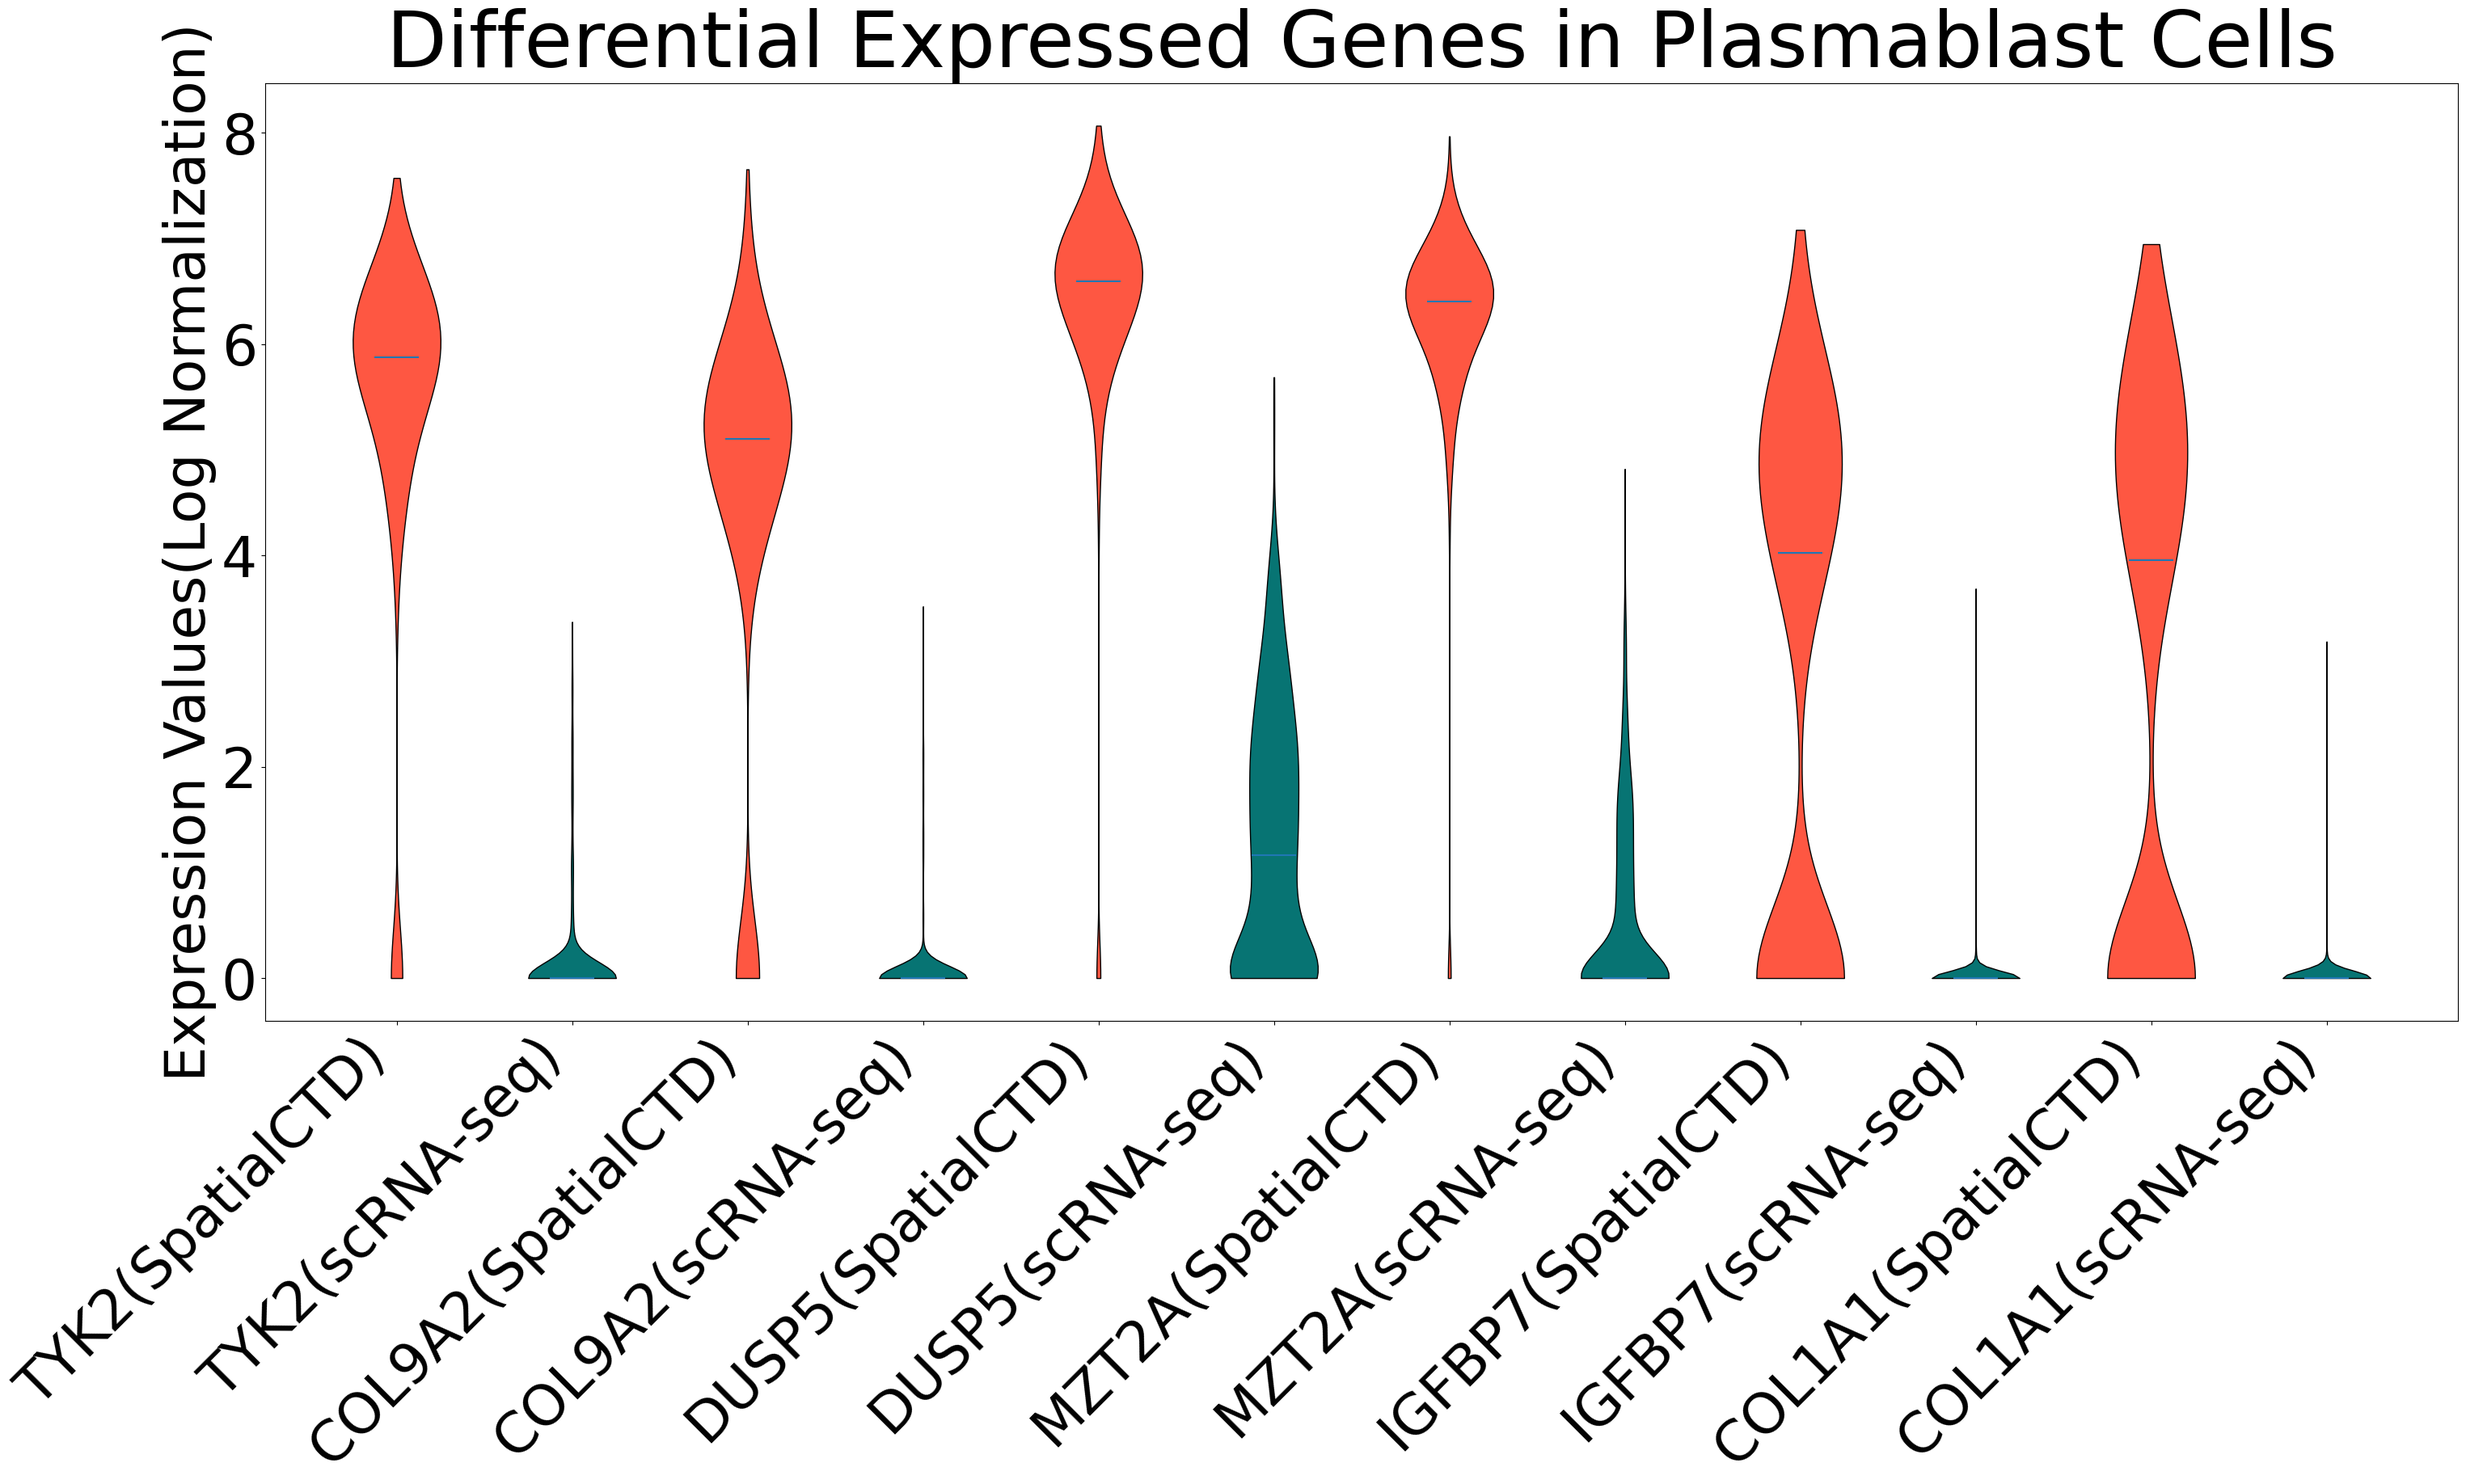

In [158]:
import matplotlib.pyplot as plt
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation = 45, fontsize = 50,  ha='right')
    ax.set_xlim(0.25, len(labels) + 0.75)
    # ax.set_ylabel('Y Axis', fontsize=14)
    # ax.set_yticks(fontsize = 10)
    ax.tick_params(axis='y', labelsize=50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 20), sharey=True)
ax.set_ylabel("Expression Values(Log Normalization)", fontsize= 50)
ax.set_title("Differential Expressed Genes in %s"%(chosen_celltype_cosmx), fontsize= 70)
parts = ax.violinplot(
    data_plotter, showmeans=False, showmedians=True,
    showextrema=False
)
for i in range(len(parts['bodies'])):
    if i % 2 == 0:
        parts['bodies'][i].set_facecolor('#fe5742') 
    else:
        parts['bodies'][i].set_facecolor('#077473') 
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)
labels = []
for gene in DEG_up_6.index:
    labels.append(gene+str("(SpatialCTD)"))
    labels.append(gene+str("(scRNA-seq)"))



set_axis_style(ax, labels)
plt.subplots_adjust(bottom=0.30, wspace=0.05)
plt.savefig("./fig/%s_up.pdf"%(chosen_celltype_cosmx))
plt.show()